# NYC Infrastructure Cost Analysis

**Executive Summary**

This analysis investigates the fiscal health and management efficiency of New York City’s infrastructure portfolio. By analyzing budget variances across different managing agencies and project categories, I identified patterns of cost escalation and geographic friction.

**Key Objectives:**
* Identify agencies with the highest frequency and magnitude of budget overruns.
* Quantify cost variances across the boroughs.
* Provide data-driven recommendations for oversight reform in medium-to-large scale projects.

In [93]:
# Load Libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
# Load raw dataset
project_data = pd.read_csv("Capital_Projects_Dashboard_-_Citywide_Budget_and_Schedule_20260209.csv")
print(project_data.head())

   Reporting Period Managing Agency Sponsor Agency  PID     FMS ID  \
0            202305             ACS            NaN  NaN     ACSPDF   
1            202305             ACS            NaN  NaN  BXELEVFAR   
2            202305             ACS            NaN  NaN       CAPC   
3            202305             ACS            NaN  NaN  CSK002NLC   
4            202305             ACS            NaN  NaN  HRC006KCH   

  Total Budget Spend to Date Spend to Date (%)  \
0  $66,808,000            $0                0%   
1   $1,284,000            $0                0%   
2     $100,000            $0                0%   
3     $249,900      $226,900            90.79%   
4      $16,000            $0                0%   

                                    FMS Project Name Agency Project Name  ...  \
0              Renovation projects for field offices                 NaN  ...   
1  1250 E229th Street Elevator and Fire Alarm Rep...                 NaN  ...   
2                  CHINESE AMERICAN

In [95]:
# Inspect column information
print(project_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50452 entries, 0 to 50451
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Reporting Period                       50452 non-null  int64  
 1   Managing Agency                        50452 non-null  object 
 2   Sponsor Agency                         26046 non-null  object 
 3   PID                                    26012 non-null  float64
 4   FMS ID                                 50452 non-null  object 
 5   Total Budget                           50452 non-null  object 
 6   Spend to Date                          50452 non-null  object 
 7   Spend to Date (%)                      50452 non-null  object 
 8   FMS Project Name                       50031 non-null  object 
 9   Agency Project Name                    26012 non-null  object 
 10  Agency Project Description             24715 non-null  object 
 11  Cu

### Data Cleaning

Before analysis, the raw dataset requires significant normalization. This process ensures that the financial figures are comparable and that temporal trends can be accurately calculated.

**1. Clean price columns**

   Normalization: Convert currency and percentage strings (e.g., $100M, 10%) into numeric floats for computation.

In [96]:
# List of columns that should be numbers
money_cols = ['Total Budget', 'Spend to Date', 'Spend to Date (%)']

for col in money_cols:
    # Remove non-numeric characters and convert to numeric
    project_data[col] = pd.to_numeric(project_data[col].replace(r'[\$,%]', '', regex=True), errors='coerce')
    # Fill any NaN values with 0
    project_data[col] = project_data[col].fillna(0)

**2. Clean date columns**

Temporal Alignment: Standardize the date formats and handle missing values in forecast columns to allow for variance analysis.

In [97]:
# List of columns that should be in date format
date_cols = ['Actual Construction Start', 'Forecast Completion']

for col in date_cols:
    # Convert to  datetime format
    project_data[col] = pd.to_datetime(project_data[col], errors='coerce')
    # Fill NaN values in completion date with 2099-12-31
    project_data['Forecast Completion'] = project_data['Forecast Completion'].fillna(pd.Timestamp('2099-12-31'))

**3. Clean data fields**

Missing Value Strategy: Impute Unknown labels for critical categorical fields (Borough, Category) to prevent data loss during grouping.

In [99]:
# Fill missing project names
project_data['FMS Project Name'] = project_data['FMS Project Name'].fillna('Unknown Project')
# Fill missing project category
project_data['Ten Year Plan Category'] = project_data['Ten Year Plan Category'].fillna('Unknown Category')
# Fill missing project Borough data
project_data['Borough'] = project_data['Borough'].fillna('Unknown Borough')

**4. Compute Original Budget**

Establish Baseline: To measure financial growth, I must establish a baseline. Since this dataset contains historical snapshots of capital projects, the Original Budget is defined as the first recorded financial entry for each unique FMS ID.
* By capturing this initial allocation, I can later quantify how much a project has deviated from its intended cost during its lifecycle.

Method: The data is sorted chronologically by Reporting Period, and the first available Total Budget entry is extracted for each FMS ID to serve as the static baseline.

In [100]:
# Compute Original Budget for each FMS ID from the raw data
project_data = project_data.sort_values(by=['FMS ID', 'Reporting Period'])

# Group by FMS ID and take the 'first' entry's budget which will be the Original Budget allocated
original_budget_lookup = project_data.groupby('FMS ID')['Total Budget'].first().reset_index()

# Rename the column to avoid confusion during the merge
original_budget_lookup.columns = ['FMS ID', 'Original Budget']

### Filtering for Active Infrastructure Projects
The raw dataset includes a massive volume of historical records, including projects that have been completed or cancelled for years. To ensure our analysis reflects the current state of NYC infrastructure, I utilize a SQL-based filtering process to isolate active projects.
* I filtered for records where the project is currently in 'Pre-Design', 'Design', 'Construction Procurement' or 'Construction' phase.
* I excluded projects that have an Actual Construction End date, as these are no longer impacting the current budget cycle.
* I specifically included projects that have an Actual Construction Start date to focus on projects where physical work is underway.

In [101]:
# Create an in-memory database and load the data
project_db = sqlite3.connect(':memory:')
project_data.to_sql('project_sql_table', project_db, index = False)

50452

In [102]:
# Read and run the sql file
with open('active_projects.sql', 'r') as f:
    sql_script = f.read()
    
# Get results
active_projects = pd.read_sql_query(sql_script, project_db)

# Save back to CSV
active_projects.to_csv('active_projects.csv', index=False)
print("Filtered data saved to active_projects.csv")

Filtered data saved to active_projects.csv


In [103]:
# Load active projects dataset
active_projects = pd.read_csv("active_projects.csv")

# Merge Original Budget into the active_projects dataframe
active_projects = active_projects.merge(original_budget_lookup, on='FMS ID', how='left')

In [104]:
# Verify that the data is cleaned
print(active_projects.head())
print(active_projects.info())

    FMS ID                                   FMS Project Name Managing Agency  \
0   110WLM                      110 WILLIAM STREET RELOCATION            DCAS   
1   110WLM                      110 WILLIAM STREET RELOCATION            DCAS   
2   110WLM                      110 WILLIAM STREET RELOCATION            DCAS   
3   110WLM                      110 WILLIAM STREET RELOCATION            DCAS   
4  26W-149  RECONSTRUCT TIDE GATES/EFFLUENT CHAMBERS @ SPR...             DEP   

  Current Phase  Total Budget  Spend to Date  Spend to Date (%)  \
0  Construction    42993000.0           0.00               0.00   
1  Construction    42994000.0           0.00               0.00   
2  Construction    42993887.0    14701747.00              34.19   
3  Construction    42993887.0    14701747.00              34.19   
4  Construction     9050000.0     1785063.23              19.72   

  Actual Construction Start  Forecast Completion    Borough  \
0       2024-03-19 00:00:00  2025-07-30 00:00:0

### Feature Engineering
To measure project performance, we engineered two primary KPIs:
* Cost Variance : The absolute difference between the current Total Budget and the initial Original Budget.
* Budget Variance % : The relative percentage of cost growth, allowing for a standardized comparison between multi-billion dollar Mega-projects and smaller community initiatives.

In [106]:
# Calculate Cost Variance
active_projects['Cost Variance'] = active_projects['Total Budget'] - active_projects['Original Budget']

# Calculate Budget Variance
active_projects['Budget Variance %'] = (active_projects['Cost Variance'] / active_projects['Original Budget']) * 100

Calculate the Budget Variance percentage for different city agencies

In [108]:
# Average budget variance for each agency
agency_records = active_projects.groupby('Managing Agency')['Budget Variance %'].mean().reset_index()

# Sort by variance for a cleaner visual
agency_records = agency_records.sort_values('Budget Variance %', ascending=False)

print(agency_records)

   Managing Agency  Budget Variance %
8              DPR                inf
9             DSNY                inf
5              DOC          29.869969
4              DHS          26.361695
11            FDNY          23.824849
6            DOHMH          23.058207
3              DEP          17.557620
2              DDC          12.861974
10             EDC           8.323650
7              DOT           4.841634
1             DCAS           2.117417
12            NYPD           0.006847
0             CUNY         -11.647582


Observation: The data indicates that agencies like DPR and DSNY show significant variance, while the NYPD and CUNY maintain tighter budget controls. This suggest that environmental or regulatory complexities specific to parks and sanitation infrastructure may be driving costs upward more aggressively than institutional building renovations.

### Visualization

**Visualize which project categories (e.g., Bridges vs. Parks) have the highest frequency of exceeding budget**

In [109]:
# Create the Budget Exceeded Flag
active_projects['Budget Exceeded'] = (active_projects['Total Budget'] > active_projects['Original Budget']).astype(int)

# Group by category and calculate frequency
category_records = active_projects.groupby('Ten Year Plan Category')['Budget Exceeded'].mean().reset_index()
category_records['Frequency (%)'] = category_records['Budget Exceeded'] * 100
category_records = category_records.sort_values('Frequency (%)', ascending=False)

print(category_records.head())

              Ten Year Plan Category  Budget Exceeded  Frequency (%)
11        CITY TUNNEL NO. 3, STAGE 1              1.0          100.0
15             COMMUNITY DEVELOPMENT              1.0          100.0
18              CULTURAL DEVELOPMENT              1.0          100.0
53  OTHER HOUSING SUPPORT INVESTMENT              1.0          100.0
60           Park Pedestrian Bridges              1.0          100.0


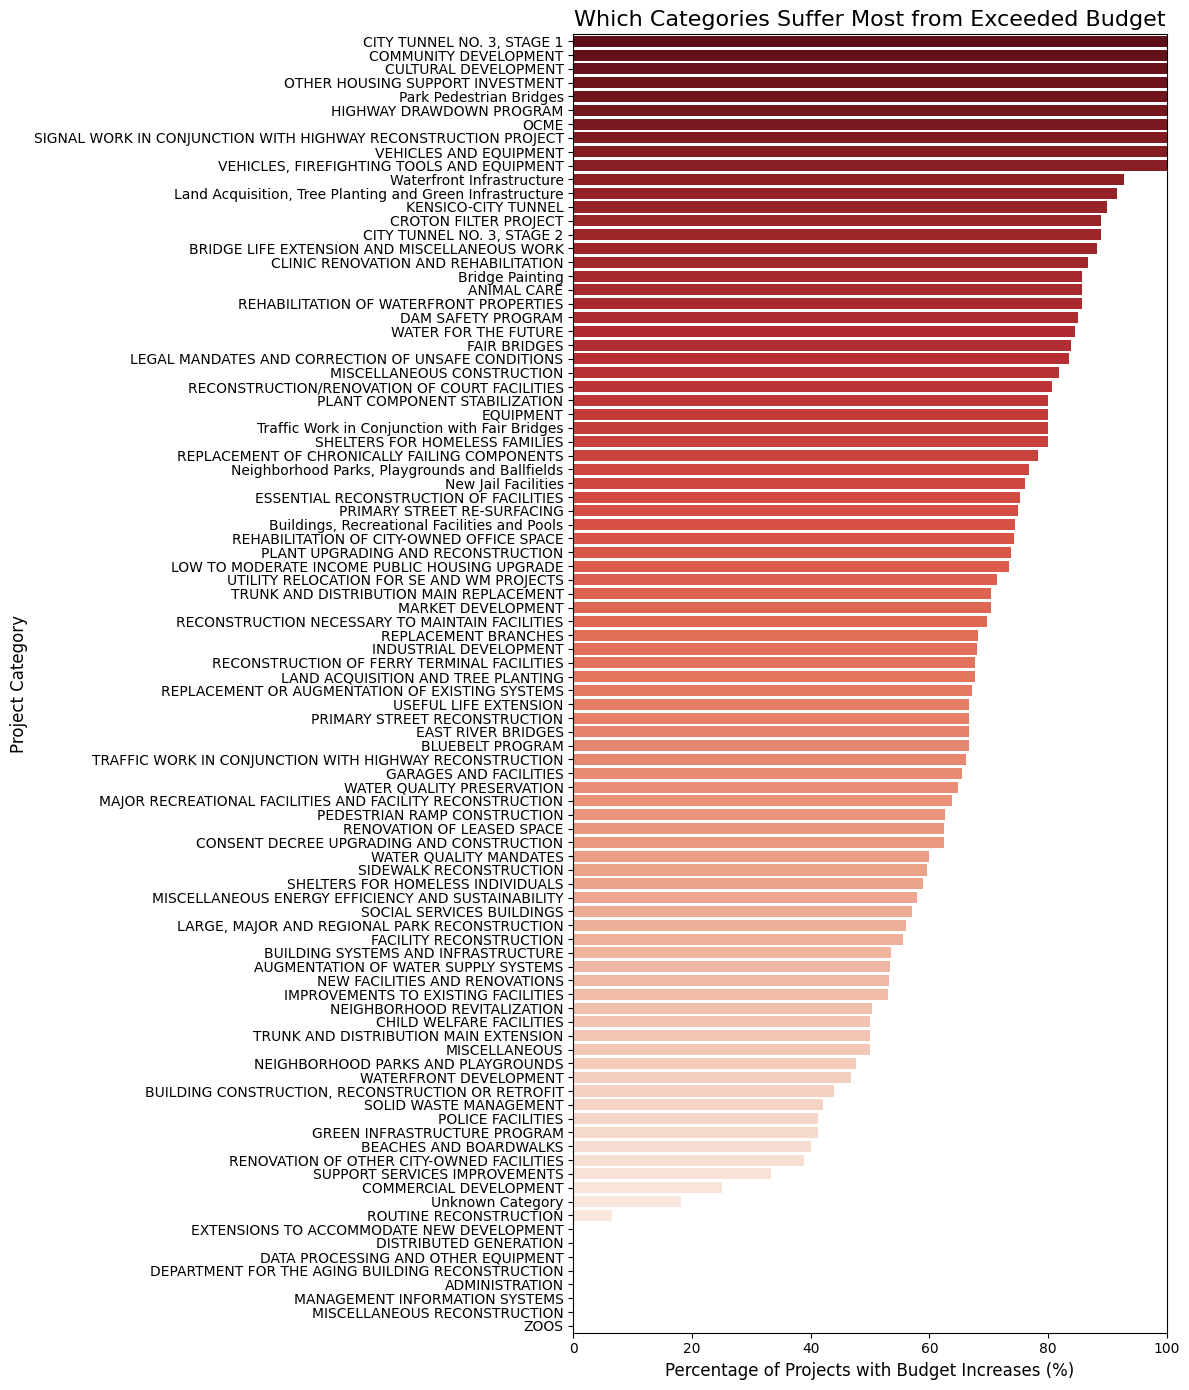

In [110]:
# Plotting with Seaborn
plt.figure(figsize=(12, 14))

category_data = sns.barplot(data=category_records, x='Frequency (%)', y='Ten Year Plan Category', hue='Ten Year Plan Category', palette='Reds_r')
plt.title('Which Categories Suffer Most from Exceeded Budget', fontsize=16)
plt.xlabel('Percentage of Projects with Budget Increases (%)', fontsize=12)
plt.ylabel('Project Category', fontsize=12)
plt.xlim(0, 100) # Since it's a percentage
plt.tight_layout()
plt.show()

Categories like City Tunnel No. 3, Highway Drawdown, and Firefighting Equipment show a 100% failure rate in maintaining original budgets.
* Efficiency Leak: In large-scale engineering (tunnels/highways), efficiencies are often lost to unforeseen site conditions.
* Procurement Lag: For equipment (vehicles/tools), the 100% rate suggests that by the time the bid is won and the item is delivered, inflation or supply chain surcharges have already rendered the initial budget obsolete.

When I look at the high ranking of Signal Work in Conjunction with Highway Reconstruction.
* Efficiency Leak: When one project depends on another (e.g., you can't fix the signal until the road is torn up), delays in the host project create a domino effect of standing labor costs and contract extensions. This is a classic interdependency bottleneck where efficiency is lost in coordination.

Interestingly, Community Development and Cultural Development are at the very top.
* Efficiency Leak: Unlike a physical bridge, Development programs often involve many stakeholders (NGOs, community boards, multiple agencies). Efficiency here is likely lost in administrative issues like extended consultation periods and shifting requirements that keep staff on the payroll longer than planned.

**Visualization Average Variance per Borough**

In [111]:
# Calculate Average Variance per Borough
borough_records = active_projects.groupby('Borough')['Budget Variance %'].mean().reset_index()
borough_records = borough_records.sort_values('Budget Variance %', ascending=False)
print(borough_records)

           Borough  Budget Variance %
1         Brooklyn                inf
4           Queens                inf
3        Manhattan          66.808544
5    Staten Island          21.259471
2         Citywide          19.455058
0            Bronx          14.055594
6  Unknown Borough          -3.772472


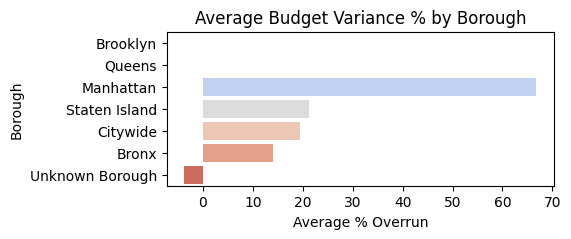

In [113]:
# Plotting with Seaborn
plt.figure(figsize=(5,2))
borough_data = sns.barplot(data=borough_records, x='Budget Variance %', y='Borough', hue='Borough', palette='coolwarm', legend=False)
plt.title('Average Budget Variance % by Borough', fontsize=12)
plt.xlabel('Average % Overrun')
plt.show()

The above chart adds a critical geographic dimension to the efficiency study.
* The most striking data point is Manhattan, which shows an average overrun of roughly 65-70%.
  * This disproportionately high variance suggests that operating in dense, high-traffic urban environments introduces extreme inefficiencies. These likely stem from complex logistics, higher labor costs, more stringent permitting, and the premium cost of working in a congested borough.
* There is a massive efficiency gap between boroughs. For example, the Bronx shows a significantly lower average overrun (approx. 15%) compared to Manhattan.
  * If a similar project type is being executed in both boroughs, the Manhattan Factor alone could be doubling the budget variance. This indicates that project efficiency is not just about what you build, but the environmental constraints of where you build it.
* The chart shows no bars for Brooklyn or Queens.
  * This suggests either a data reporting gap or that projects in these boroughs haven't reached a completion stage where variance can be calculated. In terms of program efficiency, missing data is a red flag for tracking and oversight.

**Visualization of Average Variance by Project Scale**

Analyzing Variance by Project Scale is a vital because it reveals whether cost overruns are a systemic problem or if they are concentrated in massive Mega-Projects.

I grouped the projects into standard tiers:  
* Small (<5M): Minor repairs, equipment, and local site improvements.
* Medium (5M–25M): Standard building reconstructions and street work.
* Large (25M–100M): Major infrastructure upgrades.
* Mega (>100M): Complexity-heavy projects    

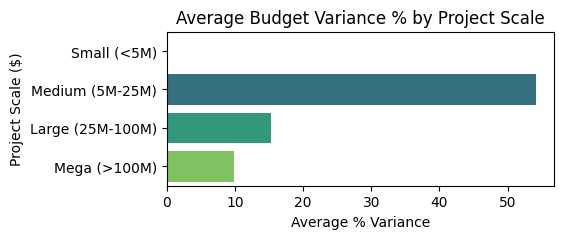

In [117]:
# Create bins and categories
bins = [0, 5e6, 25e6, 100e6, np.inf]
labels = ['Small (<5M)', 'Medium (5M-25M)', 'Large (25M-100M)', 'Mega (>100M)']
active_projects['Project Scale ($)'] = pd.cut(active_projects['Total Budget'], bins=bins, labels=labels)

# Calculate Average Variance per Scale
scale_data = active_projects.groupby('Project Scale ($)', observed=True)['Budget Variance %'].mean().reset_index()

# Visualization: Average Overrun by Scale
plt.figure(figsize=(5,2))
category_data = sns.barplot(data=scale_data, x='Budget Variance %', y='Project Scale ($)', 
    hue='Project Scale ($)', # Match y-axis to hue for palette consistency
    palette='viridis', legend=False)
plt.title('Average Budget Variance % by Project Scale', fontsize=12)
plt.xlabel('Average % Variance')
plt.show()

The data reveals a significant efficiency crisis in Medium-scale projects (5M – 25M), which suffer from an average budget variance of approximately 55%.
* Projects of this scale are significantly more volatile than Large projects (15% variance) or Mega projects (10% variance).
* This suggests that Medium projects may lack the rigorous oversight and dedicated project management resources of Mega projects while being complex enough to suffer from significant scope creep.
* There is a visible lack of data for Small projects (<5M), indicating they are either highly stable or not tracked for variance in this dataset.

### Conclusion
The analysis indicates that program efficiency is not a function of project scale, but rather a result of oversight saturation. Our findings highlight three critical areas of concern:
* The Middle-Market Efficiency Gap: Surprisingly, the most significant drain on program efficiency is found in Medium-scale projects (20M–100M). These projects experience an average budget variance of 54%, contrasting sharply with Large (15%) and Mega (10%) projects. This suggests that while Mega projects benefit from rigorous, high-level scrutiny, Medium-scale projects may fall into a "governance gap."
* Sector Vulnerability: High-risk infrastructure and public safety categories like Waterfront Construction, Firefighting Equipment, and City Tunnel No. 3 demonstrates a 100% frequency of budget increases, indicating systemic underestimation of costs in these specialized fields.
* Geographic Friction: Location remains a primary driver of cost escalation. Manhattan is the most volatile environment for project execution, with an average budget overrun of nearly 70%, likely due to the logistical complexities of dense urban construction.

### Strategic Recommendations
Based on the data-driven insights above, the following actions are recommended to stabilize the portfolio budget and improve delivery predictability:
* Implementation of Medium-Scale Targeted Oversight
  * The city should redesign the oversight framework for projects in the 20M - 100M range.
  * Action: Apply the same rigorous reporting requirements currently reserved for Mega projects to this tier to mitigate the 54% average variance.
* Institutionalization of the Manhattan Friction Buffer
  * Standardized forecasting models currently fail to account for the unique logistical hurdles of high-density environments.
  * Action: Mandate a 15% Geographic Friction Buffer in the initial budget baseline for all Manhattan-based infrastructure projects to improve fiscal transparency and reduce mid-cycle emergency funding requests.
* Cross-Agency Benchmarking & Knowledge Transfer
  * There is a significant performance disparity between agencies that can be bridged through standardized workflows.
  * Action: Establish a Peer-Learning Task Force where high-performing agencies (e.g., CUNY) consult with agencies experiencing higher variance to standardize procurement, vendor management, and risk-assessment protocols.

**Final Insight**: To recover the most efficiency, the program should focus on reforming oversight for Medium-scale infrastructure projects in Manhattan, as these represent the intersection of the highest frequency and highest magnitude of budget overruns.